## Load pre-processed adata and impute highly variable genes using MAGIC

In [1]:
import scvelo as scv
import scanpy as sc
import velocyto as vcy
import cellrank as cr
import loompy as lp

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
from pathlib import Path

import numpy as np
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt

import os
import sys
import logging

In [9]:
# load file path from ocean
adata_infile = '/ocean/projects/cis240075p/skeshari/igvf/bcell1/male_donor/out_data/sc_preproc/out_files/male_sc_processed.h5ad'
adata_old = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/outs/adata_aggregated_gene.leiden.h5ad"

In [10]:
# transfer the file to the scratch space
!rsync -aP $adata_infile $adata_old /dev/shm/

sending incremental file list
adata_aggregated_gene.leiden.h5ad
  1,932,669,800 100%  350.67MB/s    0:00:05 (xfr#1, to-chk=1/2)


In [11]:
adata = sc.read_h5ad(os.path.join('/dev/shm/', os.path.basename(adata_old)))

In [12]:
adata

AnnData object with n_obs × n_vars = 32418 × 23090
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_major_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'topic_dendogram', 'umap'
    obsm: 'X_joint_umap_features', 'X_topic_compositions', 'X_umap', 'X_umap_features'
    varm: 'topic_feature_activations', 'topic_feature_compositions'
    layers: 'counts'
    obsp: 'connectivities',

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


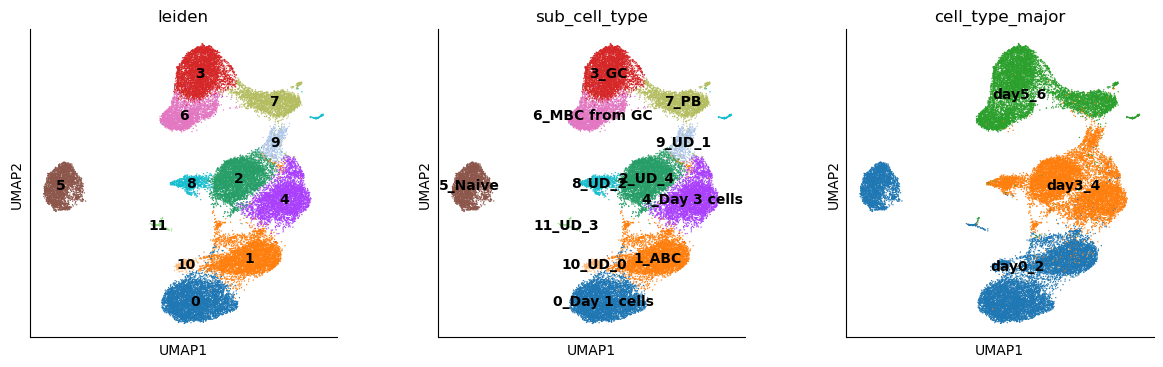

In [13]:
# First, create the sub_cell_type annotation
cluster_list = list(set(adata.obs.leiden))
annotation_2 = {
    '5': '5_Naive',
    '10': '10_UD_0',
    '9': '9_UD_1',
    '8': '8_UD_2',
    '3': '3_GC',
    '11': '11_UD_3',
    '1': '1_ABC',
    '0': '0_Day 1 cells',
    '7': '7_PB',
    '4': '4_Day 3 cells',
    '6': '6_MBC from GC',
    '2': '2_UD_4'
}

# Create sub_cell_type observation
adata.obs["sub_cell_type"] = [annotation_2[i] for i in adata.obs.leiden]

# Convert to categorical
adata.obs['sub_cell_type'] = pd.Categorical(adata.obs['sub_cell_type'])

# Get leiden colors
leiden_colors = adata.uns['leiden_colors']

# Create mapping between leiden clusters and their colors
color_dict = {str(i): color for i, color in enumerate(leiden_colors)}

# Create mapping using the actual leiden to sub_cell_type relationships
sub_cell_type_colors = {
    '5_Naive': color_dict['5'],
    '10_UD_0': color_dict['10'],
    '9_UD_1': color_dict['9'],
    '8_UD_2': color_dict['8'],
    '3_GC': color_dict['3'],
    '11_UD_3': color_dict['11'],
    '1_ABC': color_dict['1'],
    '0_Day 1 cells': color_dict['0'],
    '7_PB': color_dict['7'],
    '4_Day 3 cells': color_dict['4'],
    '6_MBC from GC': color_dict['6'],
    '2_UD_4': color_dict['2']
}

# Set the colors for the sub_cell_type category
adata.uns['sub_cell_type_colors'] = [sub_cell_type_colors[ct] for ct in adata.obs['sub_cell_type'].cat.categories]

# Plot with the matched colors
sc.pl.umap(adata, color=['leiden', 'sub_cell_type', 'cell_type_major'], legend_loc='on data')

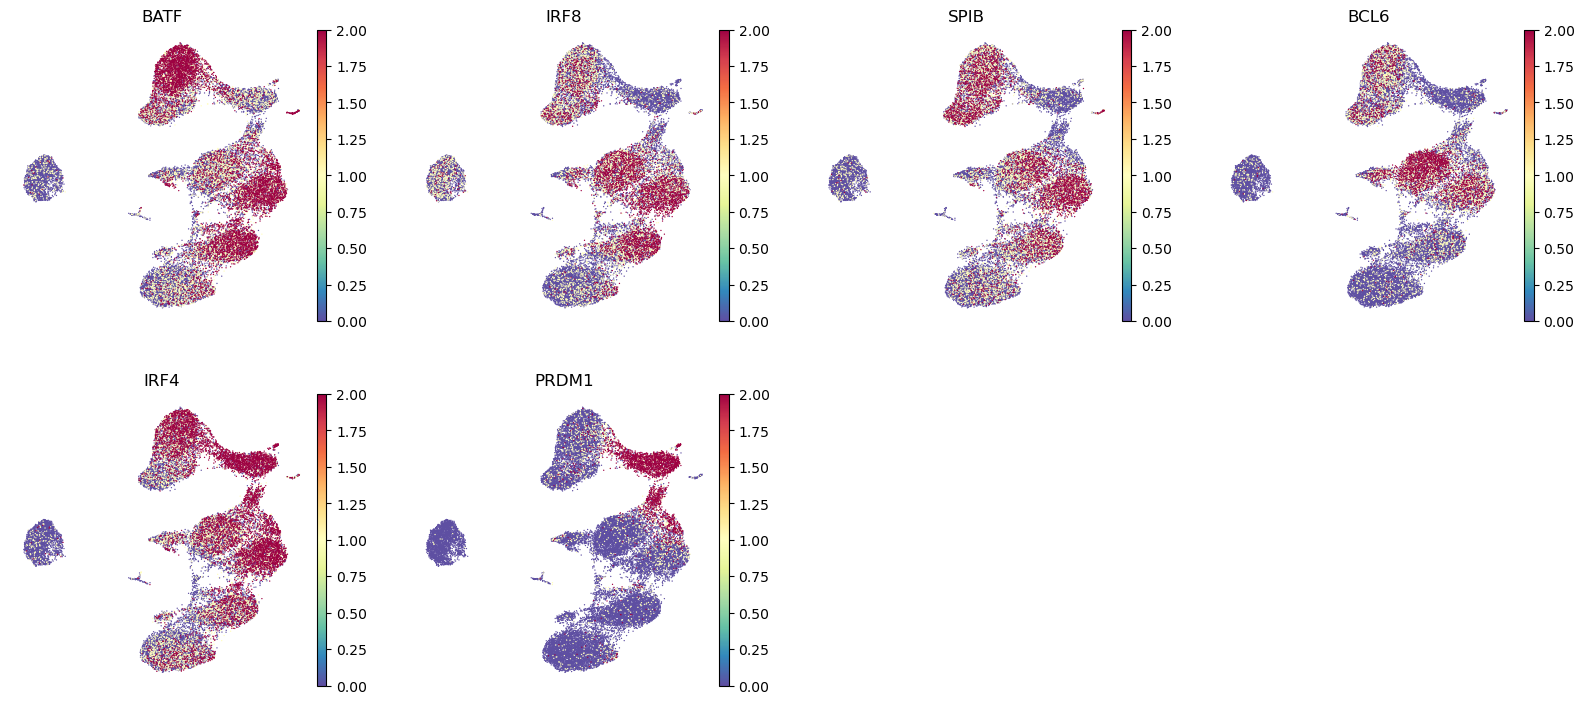

In [14]:
# pre imputation expression of 6 TFs
sc.pl.embedding(
    adata,
    basis="umap",
    layer="counts",
    color=["BATF","IRF8","SPIB","BCL6","IRF4","PRDM1"],
    vmin=0,
    vmax=2,
    frameon=False,
)
plt.show()

#### Impute only highly variable genes by using diffusion in the pca space of cells to get new nearest neighbors

In [16]:
import palantir

In [17]:
def feature_selection(adata, gene_list = None):
    sc.pp.highly_variable_genes(adata, flavor='cell_ranger',n_top_genes=3000) 
    # MODIFY FILTERED_GENES TO ADD GENES OF INTEREST
    # Overriding the bool_list to include TF of interest
    if gene_list is not None:
        for gene in gene_list:
            if adata.var['highly_variable'][gene] == False:
                adata.var['highly_variable'][gene] = True
    #subset the anndata for trajectory dimensionality reduction
    adata = adata[:, adata.var.highly_variable]
    return adata

In [18]:
TFs_of_importance = ["BATF","IRF8","SPIB","IRF4","PRDM1"]
marker_list = ["IL10", "AICDA", "IL4R", "FCER2", "BCL6", "JUN", "CD69", "JCHAIN", "CD27", "CD38", "XBP1", "MZB1", "MKI67"]
TF_perturb_list = ["BATF3","EGR1","FOS","IKZF1","IRF1","JUNB","JUND","MEF2A","MEF2C","MYB","NFATC1","NFATC2","NFIL3","NFKB1","NFKB2","PAX5","RUNX1","SP3","SPI1","STAT1","STAT5A","TCF12","VDR","XBP1","ZBTB7A"]

# # subset the anndata to only include the highly variable genes
# adata = adata[:, adata.var.highly_variable]

gene_list = list(set(marker_list).union(set(TF_perturb_list)).union(set(TFs_of_importance)))
adata = feature_selection(adata, gene_list) 

In [19]:
# check if new adata has var names of interest from the TFs_of_importance list
print(adata.var.highly_variable[TFs_of_importance])
# print how many true values are in the highly_variable column
print(adata.var.highly_variable.sum())
adata


BATF     True
IRF8     True
SPIB     True
IRF4     True
PRDM1    True
Name: highly_variable, dtype: bool
3018


View of AnnData object with n_obs × n_vars = 32418 × 3018
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'sub_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_major_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'topic_dendogram', 'umap', 'sub_cell_type_colors', 'hvg'
    obsm: 'X_joint_umap_features', 'X_topic_compositions', 'X_umap', 'X_umap_features

#### Check PCA to reduce dimensionality for diffusion step recalculation of cell-cell similarities

In [20]:
# default pca function gives bad results (palantir.utils.run_pca(adata, n_components=50))
def dim_reduction(adata):
    #Scale before running PCA
    sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
    sc.pp.scale(adata, max_value=10)
    sc.pp.pca(adata)
    sc.pl.pca_variance_ratio(adata, n_pcs=20, log=True)
    return adata

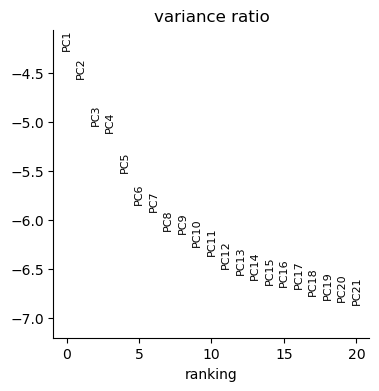

AnnData object with n_obs × n_vars = 32418 × 3018
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'sub_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_major_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'topic_dendogram', 'umap', 'sub_cell_type_colors', 'hvg', 'pca'
    obsm: 'X_joint_umap_features', 'X_topic_compositions', 'X_umap', 'X

In [21]:
adata = dim_reduction(adata)
adata

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


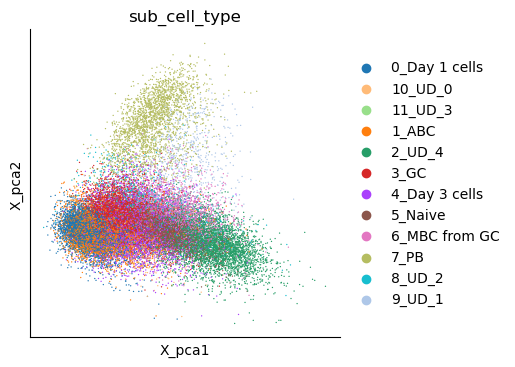

In [22]:
# plot using X_pca
sc.pl.embedding(adata, basis='X_pca', color=['sub_cell_type'])


#### Run diffusion maps to get cell-cell similarities

In [26]:
palantir.utils.run_diffusion_maps(adata,n_components=10) #n_components, select from the plot above, knn = 30 by default for graph construction
adata


AnnData object with n_obs × n_vars = 32418 × 3018
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'sub_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_major_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'topic_dendogram', 'umap', 'sub_cell_type_colors', 'hvg', 'pca', 'DM_EigenValues'
    obsm: 'X_joint_umap_features', 'X_topic_compositi

#### Run imputation 

In [27]:
palantir.utils.run_magic_imputation(adata)


array([[0.13338044, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.03445005, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0141973 ]], dtype=float32)

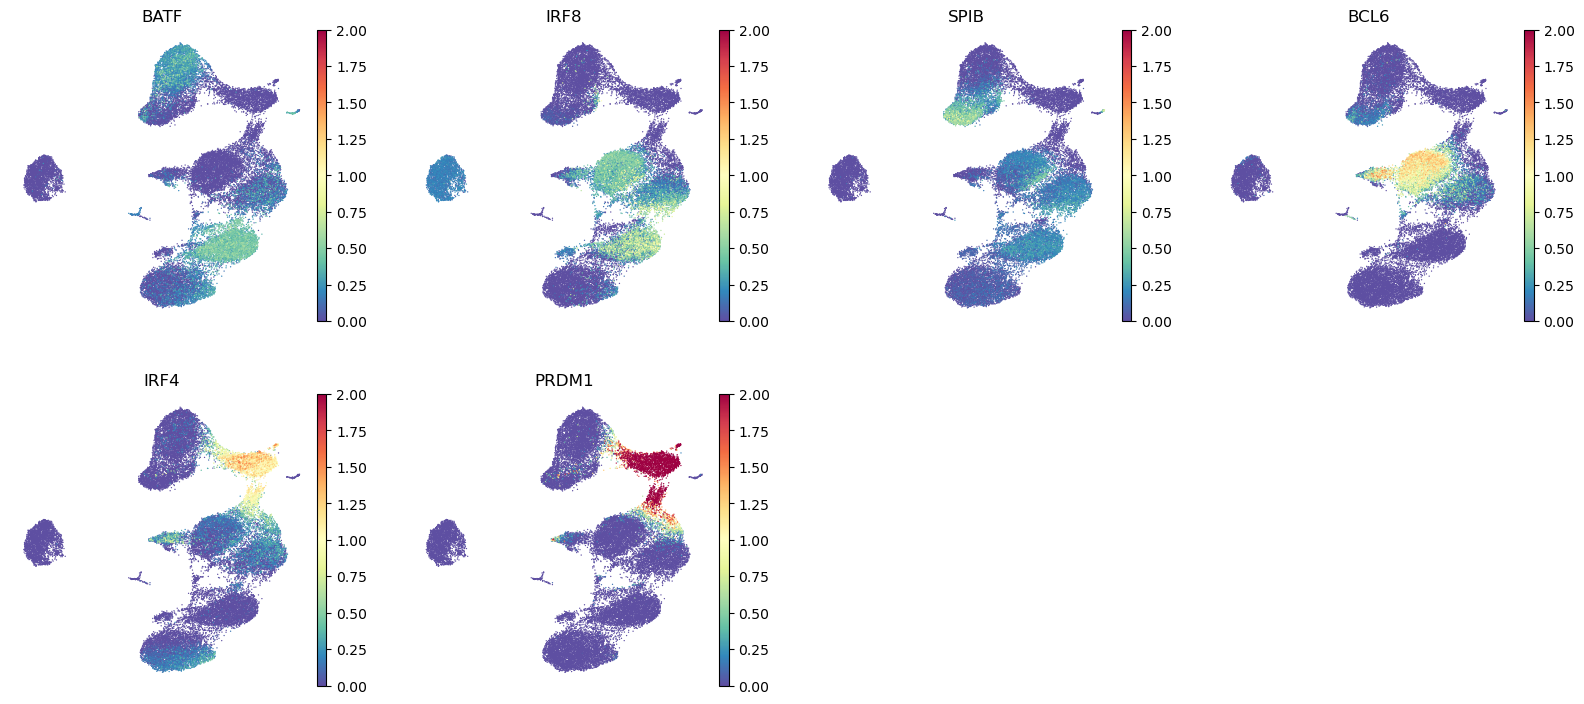

In [28]:
# plot post imputation expression of 5 TFs
sc.pl.embedding(
    adata,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=["BATF","IRF8","SPIB","BCL6","IRF4","PRDM1"],
    vmin=0,
    vmax=2,
    frameon=False,
)
plt.show()


In [29]:
# save the updated adata
adata.write_h5ad("/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/multiome_rna_imputed_v2.h5ad")


#### Plot histogram of counts per gene for the imputed data layer to compare with the original data layer

In [30]:
adata = sc.read_h5ad("/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/multiome_rna_imputed_gene_all.h5ad")

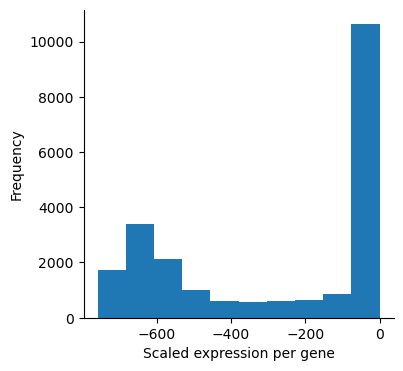

In [31]:
plt.hist(adata.X.sum(axis=0))
#label the axes
plt.xlabel('Scaled expression per gene')
plt.ylabel('Frequency')
plt.show()

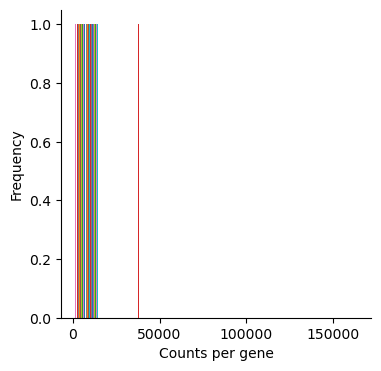

In [28]:
adata.X = adata.layers['counts']
plt.hist(adata.X.sum(axis=0))
#label the axes
plt.xlabel('Counts per gene')
plt.ylabel('Frequency')
plt.show()


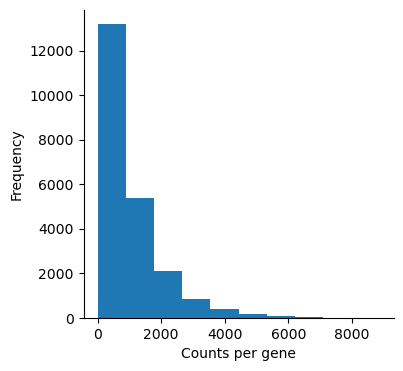

In [27]:
adata.X = adata.layers['MAGIC_imputed_data']
plt.hist(adata.X.sum(axis=0))
#label the axes
plt.xlabel('Post imputation expression per gene')
plt.ylabel('Frequency')
plt.show()


# Filter day 0,1 cells for stream input

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


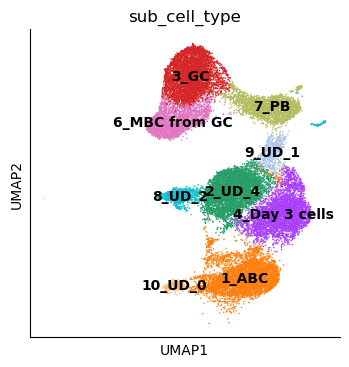

In [30]:
# subset the anndata to only include the cells that are in the sub_cell_type categories of interest
adata=adata[adata.obs['sub_cell_type'].isin(['10_UD_0','1_ABC','4_Day 3 cells','8_UD_2','2_UD_4','3_GC','6_MBC from GC','9_UD_1','7_PB'])]
sc.pl.umap(adata,color=['sub_cell_type'],legend_loc='on data')


In [31]:
# save the anndata
adata.write('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_input_filtered_cells_v2.h5ad')